# Kernel Derivatives

**Linear Operators and Stochastic Partial Differential Equations in GPR** - Simo Särkkä - [PDF](https://users.aalto.fi/~ssarkka/pub/spde.pdf)

> Expresses derivatives of GPs as operators

[**Demo Colab Notebook**](https://colab.research.google.com/drive/1pbb0qlypJCqPTN_cu2GEkkKLNXCYO9F2)

He looks at ths special case where we have a GP with a mean function zero and a covariance matrix $K$ defined as:
$$
\mathbb{E}[f(\mathbf{x})f^\top(\mathbf{x'})] = K_{ff}(\mathbf{x,x'})
$$
So in GP terminology:
$$
f(\mathbf(x)) \sim \mathcal{GP}(\mathbf{0}, K_{ff}(\mathbf{x,x'}))
$$
We use the rulse for linear transformations of GPs to obtain the different transformations of the kernel matrix. 

Let's define the notation for the derivative of a kernel matrix. Let $g(\cdot)$ be the derivative operator on a function $f(\cdot)$. So:
$$
g(\mathbf{x}) = \mathcal{L}_x f(\mathbf{x})
$$

So now, we want to define the cross operators between the derivative $g(\cdot)$ and the function $f(\cdot)$. 

**Example**: He draws a distinction between the two operators with an example of how this works in practice. So let's take the linear operator $\mathcal{L}_{x}=(1, \frac{\partial}{\partial x})$. This operator:

* acts on a scalar GP $f(x)$
* a scalar input $x$ 
* a covariance function $k_{ff}(x,x')$ 
* outputs a scalar value $y$



We can get the following transformations:
$$
\begin{aligned}
K_{gf}(\mathbf{x,x'})
&= \mathcal{L}_x f(\mathbf{x}) f(\mathbf{x}) = \mathcal{L}_xK_{ff}(\mathbf{x,x'}) \\
K_{fg}(\mathbf{x,x'})
&= f(\mathbf{x}) f(\mathbf{x'}) \mathcal{L}_{x'} = K_{ff}(\mathbf{x,x'})\mathcal{L}_{x'} \\
K_{gg}(\mathbf{x,x'})
&= \mathcal{L}_x f(\mathbf{x}) f(\mathbf{x'}) \mathcal{L}_{x'}
= \mathcal{L}_xK_{ff}(\mathbf{x,x'})\mathcal{L}_{x'}^\top \\
\end{aligned}
$$

In [ ]:
#@title Packages
import functools

import jax
import jax.numpy as jnp
import numpy as onp
from sklearn.metrics.pairwise import rbf_kernel as rbf_sklearn
# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

In [ ]:
#@title Plot Functions

def plot_kernel_mat(K):
    # plot
    plt.figure()
    plt.imshow(K, cmap='Reds')
    plt.title(r'$K_{ff}$, (rbf)', fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
#@title Data

def get_1d_data(N=30, sigma_inputs=0.15, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-10, 10, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X))
    Y += sigma_obs * onp.random.randn(N)
    X += sigma_inputs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X_test = jnp.linspace(-11, 11, N_test) 
    X_test += sigma_inputs * onp.random.randn(N_test)

    X = X[:, None]
    X_test = X[:, None]

    assert X.shape == (N,1)
    assert Y.shape == (N,)

    return X, Y, X_test

def get_2d_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X1 = jnp.linspace(-10, 10, N)
    X2 = jnp.linspace(-5, 2, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X1)) + jnp.exp(X2)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X1_test = jnp.linspace(-11, 11, N_test)
    X2_test = jnp.linspace(-6, 4, N_test) 

    X = jnp.vstack((X1,X2)).T
    X_test = jnp.vstack((X1_test,X2_test)).T

    assert X.shape == (N,2)
    assert Y.shape == (N,)

    return X, Y, X_test

# Get Data
X, Y, X_test = get_1d_data(100, sigma_inputs=0.0, sigma_obs=0.1, N_test=100)

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Kernel Function


$$
\text{dist} = \sum_{i=1}^D (\mathbf{x_i} - \mathbf{y_i})^2
$$

In [ ]:
#@title Kernel Functions

# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    return jnp.exp( - params['gamma'] * sqeuclidean_distance(x, y))
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

#### RBF Kernel

In [ ]:
X.shape

(10, 2)

In [ ]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X[:1, :]
test_Y = X[:1, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X.reshape(1, -1)), 
    onp.array(test_Y.reshape(1, -1)), 
    gamma=1.0
)
print(rbf_x_sk.shape, test_X.shape)

params = {'gamma': 1.0, 'var_f': 1.0}
gamma = 1.0
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = rbf_k_(
    test_X.squeeze(), 
    test_Y.squeeze()
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

(1, 1) (1, 2)


### Kernel Matrix

We defined all of our functions above with only dimensions in mind, not the number of samples or the batch size. So we need to account for that. So if we wanted to calculate the kernel matrix, we would have to loop through all of the samples and calculate the products individually, which would take a long time; especially for large amounts of data. 

> Avoid Loops at all cost in python...

Fortunately, Jax has this incredible function `vmap` which handles batching automatically at apparently, no extra cost. So we can write our functions to account for vectors without having to care about the batch size and then use the `vmap` function to essentially "vectorize" our functions. It essentially allows us to take a product between a matrix and a sample or two vectors of multiple samples. Let's go through an example of how we can construct our kernel matrix.

1. We need to map all points with one vector to another.

We're going to take a single sample from $X'$ and take the rbf kernel between it and all of $X$. So:

$$\text{vmap}_f(\mathbf{X}, \mathbf{x})$$

where $X\in \mathbb{R}^{N \times D}$ is a matrix and $\mathbf{x} \in \mathbb{R}^{D}$ is a vector.

In [ ]:
# Gram Matrix
def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

In [ ]:
# map function 1
mapx1 = jax.vmap(lambda x, y: rbf_kernel(params, x, y), in_axes=(0, None), out_axes=0)

# test the mapping
x1_mapped = mapx1(X, X[0, :])

# Check output shapes, # of dimensions
assert x1_mapped.shape[0] == X.shape[0]   
assert jnp.ndim(x1_mapped) == 1   

This that's good: we have an array of size $N$. So we've effectively mapped all points from one array to the other. 

So now we can do another vector mapping which allows us to take all samples of $X'$ and map them against all samples of $X$. So it'll be a `vmap` of a `vmap`. Then we'll get the $N\times N$ kernel matrix.

In [ ]:
mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)

K = mapx2(X, X)

# Check output shapes, # of dimensions
assert K.shape[0] == X.shape[0], X.shape[0]   
assert jnp.ndim(K) == 2     

rbf_x_sk = rbf_sklearn(X, X, 1.0)


onp.testing.assert_array_almost_equal(onp.array(rbf_x_sk), K)

So great! We now have our kernel matrix. Let's plot it and check to see if it matches the manually constructed kernel matrix.

Great! We have a vectorized kernel function and we were still able to construct our functions in terms of vectors only! This is nice for me personally because I've always struggled with understanding some of the coding when trying to deal with samples/batch-sizes. Most pseudo-code is written in vector format so paper $\rightarrow$ has always been a painful transition for me. So now, let's wrap this in a nice function so that we can finish "wrap up" this model.

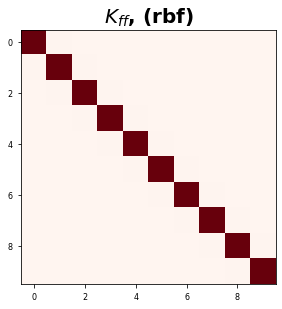

In [ ]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X.copy()#[:2, :]
test_Y = X.copy() #[:2, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X), 
    onp.array(test_Y), 
    gamma=1.0
)

params = {'gamma': 1.0, 'var_f': 1.0}
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = covariance_matrix(
    rbf_k_,
    test_X, 
    test_Y
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

plot_kernel_mat(rbf_x)

In [ ]:
#@title Tests

kx = rbf_kernel(params, X[0], X[0])

# check, the output should be 1.0
assert kx == 1.0, f"Output: {kx}"

kx = rbf_kernel(params, X[0], X[1])

# check, the output should NOT be 1.0
assert kx != 1.0, f"Output: {kx}"


# dk_dx = drbf_kernel(gamma, X[0], X[0])

# # check, the output should be 0.0
# assert dk_dx == 0.0, f"Output: {dk_dx}"

# dk_dx = drbf_kernel(gamma, X[0], X[1])

# # check, the output should NOT be 0.0
# assert dk_dx != 0.0, f"Output: {dk_dx}"

In [ ]:
#@title Speed Test
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(x))(y)

rbf_K = functools.partial(rbf_kernel, params)
rbf_cov =  jax.jit(functools.partial(covariance_matrix, rbf_K))
rbf_x = rbf_cov(test_X,  test_Y)


rbf_cov2 =  jax.jit(functools.partial(gram, rbf_K))
rbf_x2 = rbf_cov2(test_X,  test_Y)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), onp.array(rbf_x2))

In [ ]:
%timeit _ = rbf_cov(test_X,  test_Y)
%timeit _ = rbf_cov2(test_X,  test_Y)

1000 loops, best of 3: 201 µs per loop
10000 loops, best of 3: 203 µs per loop


Seems like they are comparable and there is no real difference.

## 1. Cross-Covariance Term - 1st Derivative


We can calculate the cross-covariance term $K_{fg}(\mathbf{x,x})$. We apply the following operation

$$
K_{fg}(x,x') = k_{ff}(\mathbf{x,x'})(1, \frac{\partial}{\partial x'})
$$
If we multiply the terms across, we get:
$$
K_{fg}(x,x') = k_{ff}(\mathbf{x,x'})\frac{\partial k_{ff}(\mathbf{x,x'})}{\partial x'}
$$

For the RBF Kernel, it's this:

$$\frac{\partial k(x,y)}{\partial x^j}=-2 \gamma (x^j - y^j) k(x,y)$$

Note: I did the derivations from scratch.

### Single Sample

In [ ]:
X, Y, X_test = get_1d_data(10, sigma_obs=0.1)

test_X = X[0:1, :]
test_Y = X[1:2, :]

#### From Scratch

From scratch, we're going to be using loops. There are more efficient ways to implement this but it's harder to mess up loops and it's also clearer what's going on. Tricks with broadcasting are often hard to read and very hard to interpret because of the change in dimensions.

In [ ]:
def drbf_kernel_scratch(gamma, X, Y):
    # initialize matrix
    dK_fg_ = onp.empty(X.shape[-1])
    
    constant = - 2 * gamma
    
    # calculate kernel matrix w. sklearn kernel
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    # loop through features/dimensions
    for idim in range(X.shape[1]):
        
        x_val = X[:, idim] - Y[:, idim]

        dK_fg_[idim] = constant * k_val *  x_val 
    return dK_fg_

In [ ]:
dK_fg_ = drbf_kernel_scratch(gamma, test_X, test_Y)

#### Jax

For Jax, we're going to use the built-in Jacobian function. **Note**: this function only allows us take the derivative of functions that output a scalar value.

In [ ]:
rbf_kernel(params, test_X[0,:], test_Y[0,:])

DeviceArray(1., dtype=float32)

In [ ]:
drbf_kernel_fg

<function jax.api.jacrev.<locals>.jacfun>

In [ ]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

# calculate for a single sample
dK_fg = drbf_kernel_fg(params, test_X[0,:], test_Y[0,:])

# check theyre the same
assert dK_fg.all() == dK_fg_.all()

### Multiple Dimensions

Now, we have the same problem but for a vector $\mathbf{x}$ instead of a single sample $x$. In this example, $\mathbf{x}$ has 2 features, $\mathbf{x} \in \mathbb{R}^2$. We're still going to do it for a single sample.

In [ ]:
# generate some data
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

# extract a single sample
test_X = X[0:1, :]
test_Y = X[1:2, :]

#### From Scratch

In [ ]:
dK_fg_ = drbf_kernel_scratch(gamma, test_X, test_Y)

#### Jax

In [ ]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

# calculate for a single sample
dK_fg = drbf_kernel_fg(params, test_X[0,:], test_Y[0,:])

# check theyre the same
assert dK_fg.all() == dK_fg_.all()

### Multiple Samples (Batches)

Now, we're going to input a matrix $\mathbf{X}$ which are stacked samples of multiple features. So $\mathbf{X} \in \mathbb{R}^{N\times D}$.

In [ ]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X
test_Y = X

#### From Scratch

In [ ]:
dK_fg_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        dK_fg_[i, j, :] = drbf_kernel_scratch(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

#### Jax



In [ ]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

K_func = functools.partial(drbf_kernel_fg, params)

# calculate kernel matrix
dK_fg = gram(K_func, test_X, test_Y)


# check
onp.testing.assert_array_almost_equal(onp.array(dK_fg), dK_fg_)

## 2. Cross-Covariance Term - 2nd Derivative

Recall the 1st derivative is:

$$\frac{\partial k(x,y)}{\partial x^j}=-2 \gamma (x^j - y^j) k(x,y)$$

So now we repeat. First we decompose the function using the product rule:


$$
\begin{aligned}
\frac{\partial^2 k(x,y)}{\partial x^{j^2}} &=
-2 \gamma (x^j - y^j) \frac{\partial }{\partial x^j} k(x,y) + k(x,y) \frac{\partial }{\partial x^j} \left[ -2 \gamma (x^j - y^j) \right]\\
\end{aligned}
$$

The first term is basically the 1st Derivative squared and the 2nd term is a constant. So after applying the derivative and simplifying, we get:

$$
\begin{aligned}
\frac{\partial^2 k(x,y)}{\partial x^{j^2}} &=
4 \gamma^2 (x^j - y^j)^2 k(x,y) -2 \gamma k(x,y)\\
&=
\left[ 4\gamma^2(x^j - y^j)^2 - 2\gamma\right] k(\mathbf{x}, \mathbf{y}) \\
&=
2 \gamma \left[ 2\gamma(x^j - y^j)^2 - 1\right] k(\mathbf{x}, \mathbf{y}) \\
\end{aligned}
$$

#### From Scratch

Recall, this is a Jacobian so we have

In [ ]:
def d2rbf_kernel_scratch_jac(gamma, X, Y):
    d2K_fg2_ = onp.empty(X.shape[-1])
    
    constant = 2 * gamma
    
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        
        # compute the xterm: 2 gamma (xj - yj)^2
        x_val = constant * (X[:, idim] - Y[:, idim]) ** 2 - 1

        # compute the derivative term
        d2K_fg2_[idim] = constant * x_val * k_val 
    return d2K_fg2_

In [ ]:
# initialize matrix
d2K_fg2_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        d2K_fg2_[i, j, :] = d2rbf_kernel_scratch_jac(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

#### Jax

So with jax, we're computing the hessian so we'll get a matrix of size $N \times N \times D \times D$. So the 2nd derivative is just the diagonal terms of $D\times D$ part.

In [ ]:
# define the cross operator K_fg(x, y), dK wrt x
dK_fg_func = jax.hessian(rbf_kernel, argnums=(1))

# fix params for kernel function
K_func = functools.partial(dK_fg_func, params)

# calculate kernel matrix
d2K_fg2 = covariance_matrix(K_func, test_X, test_Y)

# get the diagonal terms
d2K_fg2 = jnp.diagonal(d2K_fg2, axis1=2, axis2=3)

d2K_fg2.shape

(10, 10, 2)

In [ ]:
onp.testing.assert_array_almost_equal(onp.array(d2K_fg2), d2K_fg2_)

Awesome, they're the same! So that gives me hope!

## 3. Cross-Covariance Term - 2nd Derivative (Partial Derivatives)

Recall the 1st derivative is:

$$\frac{\partial k(x,y)}{\partial x^j}=-2 \gamma (x^j - y^j) k(x,y)$$

So now we repeat. First we decompose the function using the product rule. But this time, we need to do the product rule first w.r.t. $x^j$ and then w.r.t. $y^k$.

$$
\begin{aligned}
\frac{\partial^2 k(x,y)}{\partial x^j y^k} &=
-2 \gamma (x^j - y^j) \frac{\partial }{\partial y^k} k(x,y) + k(x,y) \frac{\partial }{\partial y^k} \left[ -2 \gamma (x^j - y^j) \right]\\
\end{aligned}
$$

So now let's start expanding and collapsing terms:

$$
\begin{aligned}
\frac{\partial^2 k(x,y)}{\partial x^j y^k} &=
4 \gamma^2 (x^j - y^j)(x^k - y^k) k(x,y) \\
\end{aligned}
$$

The second term should go to zero and the first term is the same except it has different dimensions (w.r.t. $y$ instead of $x$).

$$
\frac{\partial^2 k(x,y)}{\partial x^j \partial y^k} =
4 \gamma^2 (x^k - y^k)(x^j - y^j) k(\mathbf{x}, \mathbf{y})
$$

#### From Scratch

In [ ]:
def d2rbf_kernel_scratch_hessian(gamma, X, Y):
    d2K_fg2_ = onp.empty((X.shape[-1], X.shape[-1]))
    
    constant = 2 * gamma
    constant_sq = constant ** 2
    
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        for jdim in range(X.shape[1]):
        
            # x_val = constant * (1 - constant * (X[:, idim] - Y[:, idim]) * (X[:, jdim] - Y[:, jdim]))# - constant
            x_val = constant_sq * (X[:, idim] - Y[:, idim]) * (X[:, jdim] - Y[:, jdim])

            d2K_fg2_[idim, jdim] = k_val *  x_val 
    return d2K_fg2_

In [ ]:
d2K_fg2_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        d2K_fg2_[i, j, ...] = d2rbf_kernel_scratch_hessian(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

#### Jax

In [ ]:
# define the cross operator K_fg(x, y), dK wrt x
dK_fg_func = jax.hessian(rbf_kernel, argnums=(1))

K_func = functools.partial(dK_fg_func, params)
d2K_fg2 = covariance_matrix(K_func, test_X, test_Y)

d2K_fg2.shape

(10, 10, 2, 2)

In [ ]:
onp.testing.assert_array_almost_equal(onp.array(onp.diagonal(d2K_fg2, axis1=2, axis2=3 )), jnp.diagonal(d2K_fg2, axis1=2, axis2=3))

So this is good. The diagonal terms are correct but the off-diagonal entries are incorrect. I'm not entirely sure how to fix this. I can't point to the part of the equation where you would actually calculate the off-diagonal entries

In [ ]:
onp.testing.assert_array_almost_equal(onp.array(d2K_fg2), d2K_fg2_, decimal=4)

AssertionError: ignored